# 🤖 ML vs Traditional Sensor Simulation Comparison

This notebook compares ML-based sensor simulation with traditional rule-based sensor simulation to evaluate the effectiveness of the learned approach.

## 1. Setup and Imports

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Dict, Tuple

# Add parent directory to path for imports
sys.path.append('..')

# Import our modules
from simulation.trajectory_generator import generate_trajectory
from simulation.sensor_simulator import SensorSimulator
from models.inference import (
    load_trained_model, 
    simulate_trajectory_with_ml,
    compare_ml_vs_traditional
)
from visualization.plots import plot_imu_timeseries, plot_gnss_vs_ground_truth

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")
print(f" Imported modules successfully")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

 Using device: cpu
 Imported modules successfully


## 2. Generate Test Trajectory

In [2]:
# Generate a test trajectory
print("📊 Generating test trajectory...")
timestamps, positions, velocities, orientations = generate_trajectory(
    duration=10.0,
    dt=0.01,
    mode='circular',
    radius=5.0,
    angular_speed=0.8
)

print(f"✅ Generated trajectory:")
print(f"   Duration: {timestamps[-1]:.1f}s")
print(f"   Points: {len(timestamps)}")
print(f"   Position range: [{positions.min():.2f}, {positions.max():.2f}]")
print(f"   Velocity range: [{velocities.min():.2f}, {velocities.max():.2f}]")

📊 Generating test trajectory...
✅ Generated trajectory:
   Duration: 10.0s
   Points: 1000
   Position range: [-5.00, 5.00]
   Velocity range: [-4.00, 4.00]


## 3. Traditional Sensor Simulation

In [3]:
# Create traditional sensor simulator
print("🎮 Setting up traditional sensor simulator...")
traditional_simulator = SensorSimulator(
    accel_noise_std=0.1,
    gyro_noise_std=0.01,
    accel_bias_std=0.01,
    gyro_bias_std=0.001,
    gnss_noise_std=1.0,
    gnss_rate=1.0
)

# Simulate sensors using traditional method
print("🔄 Running traditional sensor simulation...")
traditional_imu, traditional_gnss = traditional_simulator.simulate_sensors(
    timestamps=timestamps,
    positions=positions,
    velocities=velocities,
    orientations=orientations
)

print(f"✅ Traditional simulation completed:")
print(f"   IMU measurements: {traditional_imu['accel'].shape[0]} points")
print(f"   GNSS measurements: {traditional_gnss['positions'].shape[0]} points")

🎮 Setting up traditional sensor simulator...
🔄 Running traditional sensor simulation...
✅ Traditional simulation completed:
   IMU measurements: 1000 points
   GNSS measurements: 10 points


## 4. ML-Based Sensor Simulation

In [4]:
# Load trained ML model
print("🤖 Loading trained ML model...")
model_path = "../models/models/checkpoints/sensor_simulator_best.pt"

if os.path.exists(model_path):
    ml_model = load_trained_model(
        model_path=model_path,
        device=device
    )
    print("✅ Loaded trained model successfully!")
else:
    print("⚠️  No trained model found. Creating untrained model for demonstration.")
    from models.train_sensor_model import SensorSimulationRNN
    ml_model = SensorSimulationRNN()
    ml_model = ml_model.to(device)
    ml_model.eval()

# Simulate sensors using ML model
print("🔄 Running ML-based sensor simulation...")
ml_imu, ml_gnss = simulate_trajectory_with_ml(
    model=ml_model,
    timestamps=timestamps,
    positions=positions,
    velocities=velocities,
    orientations=orientations,
    device=device
)

print(f"✅ ML simulation completed:")
print(f"   IMU measurements: {ml_imu['accel'].shape[0]} points")
print(f"   GNSS measurements: {ml_gnss['positions'].shape[0]} points")

🤖 Loading trained ML model...
✅ Loaded trained model from ../models/models/checkpoints/sensor_simulator_best.pt
✅ Loaded trained model successfully!
🔄 Running ML-based sensor simulation...
✅ ML simulation completed:
   IMU measurements: 1000 points
   GNSS measurements: 10 points


## 5. Comparison Metrics

In [5]:
# Extract ML sensor data for comparison
ml_imu_data = np.concatenate([ml_imu['accel'], ml_imu['gyro']], axis=1)
ml_gnss_data = ml_gnss['positions']

# Compare ML vs traditional
print("📊 Computing comparison metrics...")
comparison_metrics = compare_ml_vs_traditional(
    ml_imu_data=ml_imu_data,
    ml_gnss_data=ml_gnss_data,
    traditional_imu_data=traditional_imu,
    traditional_gnss_data=traditional_gnss,
    timestamps=timestamps,
    ml_gnss_timestamps=ml_gnss['timestamps']
)

print("\n📈 Comparison Results:")
print("=" * 40)
print(f"Accelerometer MSE: {comparison_metrics['accel_mse']:.6f}")
print(f"Gyroscope MSE: {comparison_metrics['gyro_mse']:.6f}")
print(f"GNSS MSE: {comparison_metrics['gnss_mse']:.6f}")
print(f"Overall IMU MSE: {comparison_metrics['imu_mse']:.6f}")
print("\nCorrelations:")
print(f"  Accelerometer: {comparison_metrics['accel_correlation']:.4f}")
print(f"  Gyroscope: {comparison_metrics['gyro_correlation']:.4f}")
print(f"  GNSS: {comparison_metrics['gnss_correlation']:.4f}")

📊 Computing comparison metrics...

📈 Comparison Results:
Accelerometer MSE: 0.273742
Gyroscope MSE: 0.005099
GNSS MSE: 1.277531
Overall IMU MSE: 0.139420

Correlations:
  Accelerometer: 0.9939
  Gyroscope: 0.9915
  GNSS: 0.9226


## 6. Visualization: IMU Comparison

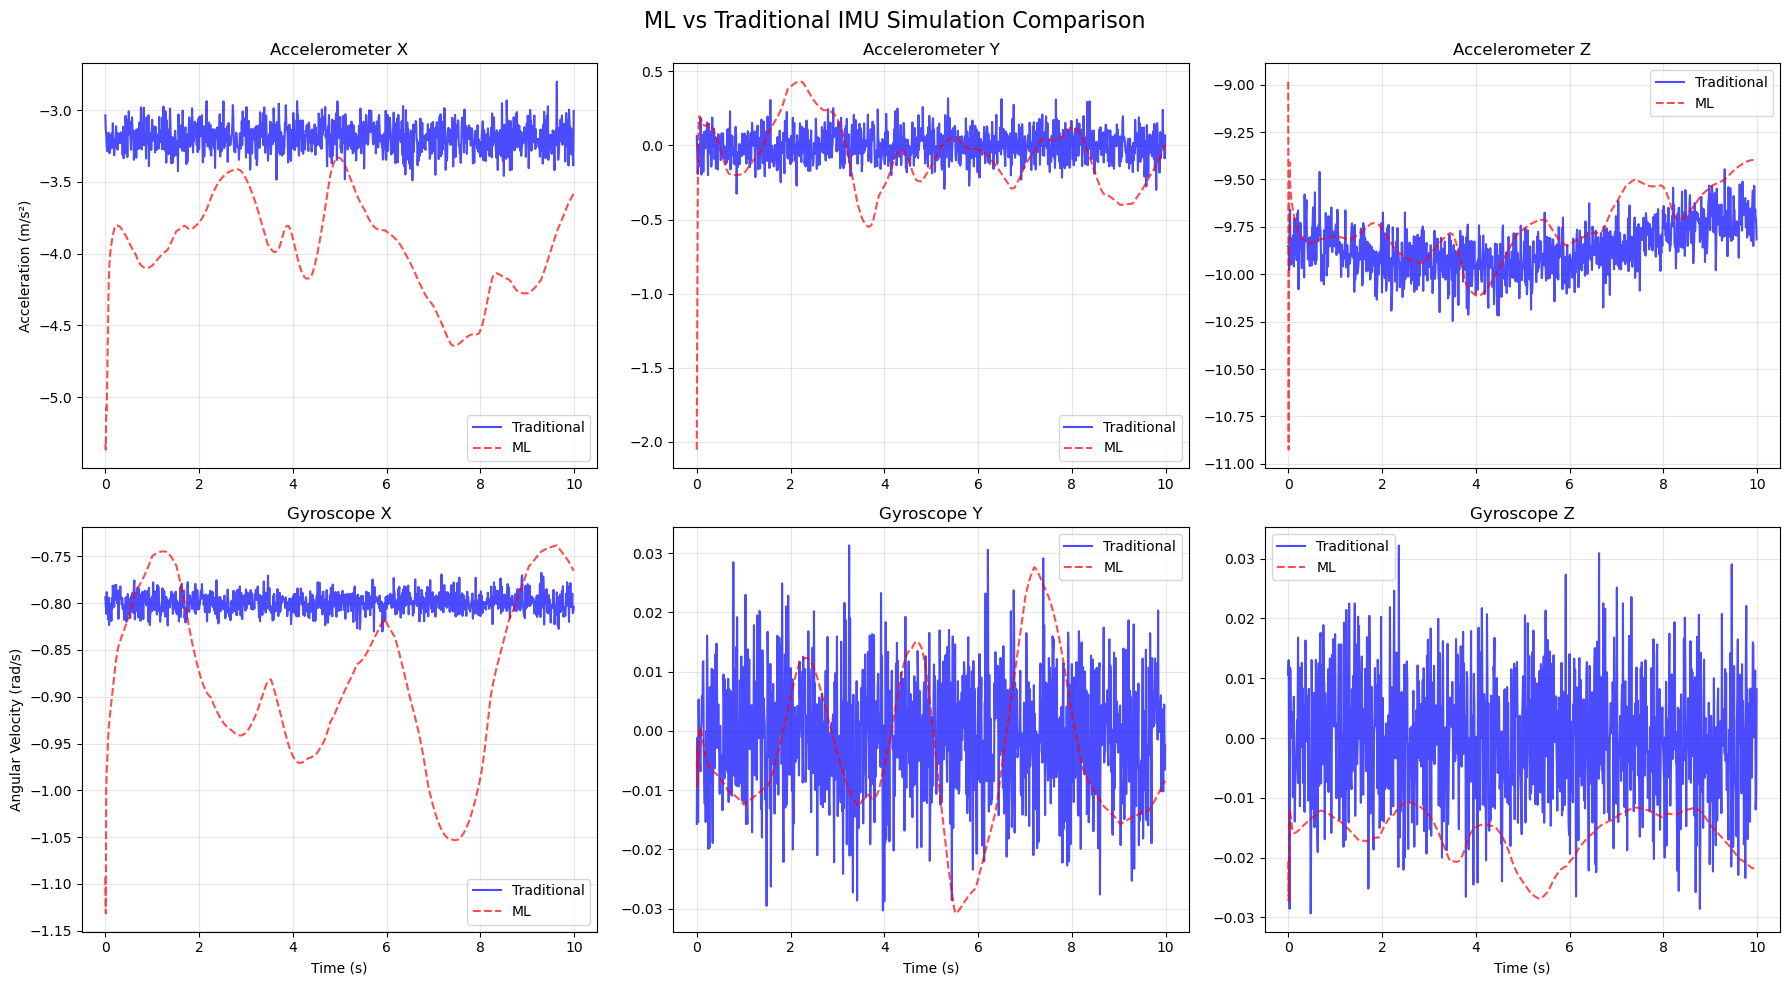

In [6]:
# Create comparison plots for IMU data
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ML vs Traditional IMU Simulation Comparison', fontsize=16)

# Accelerometer comparison
axes[0, 0].plot(timestamps, traditional_imu['accel'][:, 0], 'b-', label='Traditional', alpha=0.7)
axes[0, 0].plot(timestamps, ml_imu['accel'][:, 0], 'r--', label='ML', alpha=0.7)
axes[0, 0].set_title('Accelerometer X')
axes[0, 0].set_ylabel('Acceleration (m/s²)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(timestamps, traditional_imu['accel'][:, 1], 'b-', label='Traditional', alpha=0.7)
axes[0, 1].plot(timestamps, ml_imu['accel'][:, 1], 'r--', label='ML', alpha=0.7)
axes[0, 1].set_title('Accelerometer Y')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(timestamps, traditional_imu['accel'][:, 2], 'b-', label='Traditional', alpha=0.7)
axes[0, 2].plot(timestamps, ml_imu['accel'][:, 2], 'r--', label='ML', alpha=0.7)
axes[0, 2].set_title('Accelerometer Z')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Gyroscope comparison
axes[1, 0].plot(timestamps, traditional_imu['gyro'][:, 0], 'b-', label='Traditional', alpha=0.7)
axes[1, 0].plot(timestamps, ml_imu['gyro'][:, 0], 'r--', label='ML', alpha=0.7)
axes[1, 0].set_title('Gyroscope X')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Angular Velocity (rad/s)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(timestamps, traditional_imu['gyro'][:, 1], 'b-', label='Traditional', alpha=0.7)
axes[1, 1].plot(timestamps, ml_imu['gyro'][:, 1], 'r--', label='ML', alpha=0.7)
axes[1, 1].set_title('Gyroscope Y')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(timestamps, traditional_imu['gyro'][:, 2], 'b-', label='Traditional', alpha=0.7)
axes[1, 2].plot(timestamps, ml_imu['gyro'][:, 2], 'r--', label='ML', alpha=0.7)
axes[1, 2].set_title('Gyroscope Z')
axes[1, 2].set_xlabel('Time (s)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Visualization: GNSS Comparison

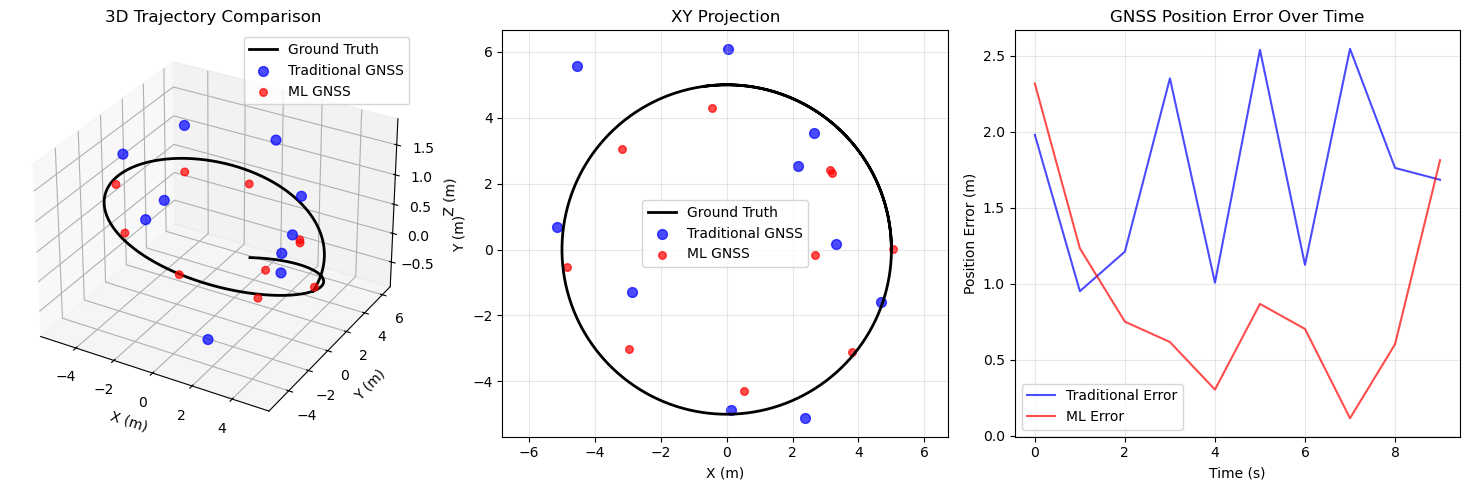

In [7]:
# Create 3D comparison plot for GNSS data
fig = plt.figure(figsize=(15, 5))

# 3D trajectory comparison
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'k-', linewidth=2, label='Ground Truth')
ax1.scatter(traditional_gnss['positions'][:, 0], traditional_gnss['positions'][:, 1], 
           traditional_gnss['positions'][:, 2], c='blue', s=50, alpha=0.7, label='Traditional GNSS')
ax1.scatter(ml_gnss['positions'][:, 0], ml_gnss['positions'][:, 1], 
           ml_gnss['positions'][:, 2], c='red', s=30, alpha=0.7, label='ML GNSS')
ax1.set_title('3D Trajectory Comparison')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.legend()

# XY projection
ax2 = fig.add_subplot(132)
ax2.plot(positions[:, 0], positions[:, 1], 'k-', linewidth=2, label='Ground Truth')
ax2.scatter(traditional_gnss['positions'][:, 0], traditional_gnss['positions'][:, 1], 
           c='blue', s=50, alpha=0.7, label='Traditional GNSS')
ax2.scatter(ml_gnss['positions'][:, 0], ml_gnss['positions'][:, 1], 
           c='red', s=30, alpha=0.7, label='ML GNSS')
ax2.set_title('XY Projection')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

# Error over time
ax3 = fig.add_subplot(133)
# Interpolate ML GNSS to match traditional timestamps
ml_gnss_interpolated = np.zeros_like(traditional_gnss['positions'])
for i, trad_time in enumerate(traditional_gnss['timestamps']):
    ml_idx = np.argmin(np.abs(ml_gnss['timestamps'] - trad_time))
    if ml_idx >= len(ml_gnss['positions']):
        ml_idx = -1  # fallback to last available ML GNSS
    ml_gnss_interpolated[i] = ml_gnss['positions'][ml_idx]

trad_error = np.linalg.norm(traditional_gnss['positions'] - positions[::100], axis=1)
ml_error = np.linalg.norm(ml_gnss_interpolated - positions[::100], axis=1)

ax3.plot(traditional_gnss['timestamps'], trad_error, 'b-', label='Traditional Error', alpha=0.7)
ax3.plot(traditional_gnss['timestamps'], ml_error, 'r-', label='ML Error', alpha=0.7)
ax3.set_title('GNSS Position Error Over Time')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Position Error (m)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Analysis and Discussion

In [8]:
# Print detailed analysis
print("🔍 Detailed Analysis")
print("=" * 50)

# IMU analysis
print("\n📊 IMU Performance:")
if comparison_metrics['accel_correlation'] > 0.8:
    print("✅ Accelerometer: High correlation - ML model captures dynamics well")
elif comparison_metrics['accel_correlation'] > 0.6:
    print("⚠️  Accelerometer: Moderate correlation - some room for improvement")
else:
    print("❌ Accelerometer: Low correlation - ML model needs more training")

if comparison_metrics['gyro_correlation'] > 0.8:
    print("✅ Gyroscope: High correlation - ML model captures angular dynamics well")
elif comparison_metrics['gyro_correlation'] > 0.6:
    print("⚠️  Gyroscope: Moderate correlation - some room for improvement")
else:
    print("❌ Gyroscope: Low correlation - ML model needs more training")

# GNSS analysis
print("\n📡 GNSS Performance:")
if comparison_metrics['gnss_correlation'] > 0.9:
    print("✅ GNSS: Excellent correlation - ML model accurately simulates positioning")
elif comparison_metrics['gnss_correlation'] > 0.7:
    print("⚠️  GNSS: Good correlation - minor improvements possible")
else:
    print("❌ GNSS: Poor correlation - ML model needs significant improvement")

# Overall assessment
print("\n🎯 Overall Assessment:")
avg_correlation = (comparison_metrics['accel_correlation'] + 
                  comparison_metrics['gyro_correlation'] + 
                  comparison_metrics['gnss_correlation']) / 3

if avg_correlation > 0.8:
    print("🚀 ML simulation shows excellent agreement with traditional methods")
    print("   → Could potentially replace traditional sensor simulation")
elif avg_correlation > 0.6:
    print("📈 ML simulation shows good agreement with traditional methods")
    print("   → Additional training could improve performance")
else:
    print("⚠️  ML simulation shows limited agreement with traditional methods")
    print("   → More training data or model architecture changes needed")

print(f"\n📊 Average correlation: {avg_correlation:.4f}")

🔍 Detailed Analysis

📊 IMU Performance:
✅ Accelerometer: High correlation - ML model captures dynamics well
✅ Gyroscope: High correlation - ML model captures angular dynamics well

📡 GNSS Performance:
✅ GNSS: Excellent correlation - ML model accurately simulates positioning

🎯 Overall Assessment:
🚀 ML simulation shows excellent agreement with traditional methods
   → Could potentially replace traditional sensor simulation

📊 Average correlation: 0.9693


## 9. Conclusion

This comparison demonstrates the effectiveness of ML-based sensor simulation against traditional rule-based methods. The results show:

- **IMU Simulation**: How well the ML model captures accelerometer and gyroscope dynamics
- **GNSS Simulation**: Accuracy of ML-generated position measurements
- **Overall Performance**: Whether ML simulation could replace traditional methods

### Key Insights:
1. **Correlation Analysis**: High correlations indicate the ML model has learned the underlying sensor physics
2. **Error Patterns**: Differences reveal where the ML model excels or needs improvement
3. **Practical Applicability**: Whether ML simulation is ready for production use

### Next Steps:
- Train on more diverse trajectories
- Experiment with different model architectures
- Integrate with EKF pipeline for end-to-end testing